# Plant Seedling Classification with Transfer Learning
Now that I've finished making a simple keras CNN, I think I'm ready to try Transfer Learning.

In [1]:
%matplotlib inline
import datetime as dt

# Import plotting for visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
#from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import numpy as np
import os.path
import pydot
import random
import itertools
import pandas as pd
from keras.applications import Xception
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.utils import layer_utils
from keras.utils import multi_gpu_model
from keras.utils.data_utils import get_file
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.applications.imagenet_utils import preprocess_input
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import sys, inspect
sys.path.append("/utils/DLWorkspace-Utils/keras-multiprocess-image-data-generator")
#import tools.image as T

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # for the confusion matrix
from sklearn.linear_model import SGDClassifier

from keras.applications.inception_v3 import InceptionV3
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import *
import os.path

from keras.applications.densenet import DenseNet201
from keras.applications.resnet50 import ResNet50

from os.path import expanduser
home = expanduser("~")

n_process = 16
import multiprocessing
pool = multiprocessing.Pool(processes=n_process)

K.set_image_data_format('channels_last')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Reading in the dataset
First, we locate our data at the correct directories.

In [2]:
data_dir = '/data/kaggle/competitions/plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
print(train_dir)
test_dir = os.path.join(data_dir, 'test')
#sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

/data/kaggle/competitions/plant-seedlings-classification/train


These are the categories we'll be using:

In [3]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)
IMAGE_SIZE = 224 # pixel height and width of each image
BATCH_SIZE = 50 

### Some data augmentation algorithms
Allows me to generate more data for my NN to train and validate on.

In [4]:
train_datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)
dev_datagen = ImageDataGenerator(rescale=1. / 255)

### Splitting the train and dev sets.
Let's split our train and validation tests 80/20.

In [5]:
split = False # we only have to do this once, so it's only set to True once.
import shutil
dev_dir = os.path.join(data_dir, 'dev')

if split:
    #os.mkdir(os.path.join(data_dir, 'dev'))
    #shutil.rmtree(dev_dir)
    for category in CATEGORIES:
        os.mkdir(os.path.join(dev_dir, category))
        imgs = os.listdir(os.path.join(train_dir, category))
        random.shuffle(imgs) 
        todev = imgs[:int(len(imgs) * .2)] # take a random 20% of the training data
        for file in todev:
            shutil.move(os.path.join(train_dir, category, file), os.path.join(dev_dir, category))

### Data specifics.
The number of files we have in the training set:

In [6]:
TOTAL_TRAIN_PICS = 0
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))
    TOTAL_TRAIN_PICS += len(os.listdir(os.path.join(train_dir, category)))
print("\nTotal Number of Training images: %s" % TOTAL_TRAIN_PICS)

Black-grass 211 images
Charlock 312 images
Cleavers 230 images
Common Chickweed 489 images
Common wheat 177 images
Fat Hen 380 images
Loose Silky-bent 524 images
Maize 177 images
Scentless Mayweed 413 images
Shepherds Purse 185 images
Small-flowered Cranesbill 397 images
Sugar beet 308 images

Total Number of Training images: 3803


The number of files we have in the dev set:

In [7]:
TOTAL_DEV_PICS = 0
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(dev_dir, category)))))
    TOTAL_DEV_PICS += len(os.listdir(os.path.join(dev_dir, category)))
print("\nTotal Number of Validation images: %s" % TOTAL_DEV_PICS)

Black-grass 52 images
Charlock 78 images
Cleavers 57 images
Common Chickweed 122 images
Common wheat 44 images
Fat Hen 95 images
Loose Silky-bent 130 images
Maize 44 images
Scentless Mayweed 103 images
Shepherds Purse 46 images
Small-flowered Cranesbill 99 images
Sugar beet 77 images

Total Number of Validation images: 947


### We can finally read in the training data!

In [8]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size= BATCH_SIZE,
        classes = CATEGORIES,
        shuffle=True,
        class_mode='categorical')

Found 3803 images belonging to 12 classes.


### And we do the same with the validation data.

In [9]:
dev_generator = dev_datagen.flow_from_directory(
        dev_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size= BATCH_SIZE,
        classes = CATEGORIES,
        shuffle=True,
        class_mode='categorical')

Found 947 images belonging to 12 classes.


## Visualizing the data

Some training data examples.


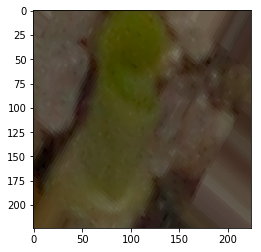

Category: Maize


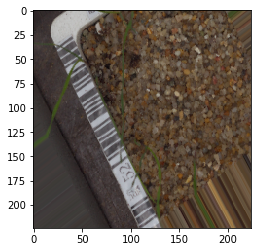

Category: Black-grass


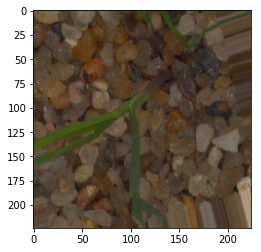

Category: Black-grass


In [10]:
print("Some training data examples.")
x_batch, y_batch = next(train_generator)
for i in range (0,3):
    image = x_batch[i]
    plt.imshow(image) # .transpose(2,1,0)
    plt.show()
    print("Category: " + str(CATEGORIES[np.argmax(y_batch[i])])) # just labeling the pictures with their categories.

Some validation data examples.


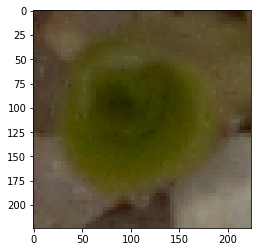

Category: Maize


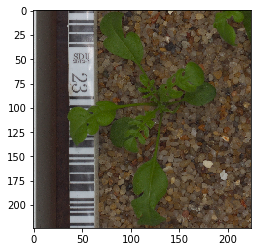

Category: Shepherds Purse


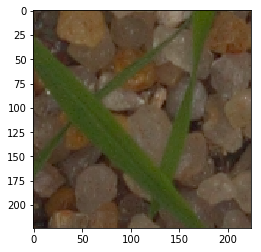

Category: Loose Silky-bent


In [11]:
print("Some validation data examples.")
x_batch, y_batch = next(dev_generator)
for i in range (0,3):
    image = x_batch[i]
    plt.imshow(image) # .transpose(2,1,0)
    plt.show()
    print("Category: " + str(CATEGORIES[np.argmax(y_batch[i])])) # just labeling the pictures with their categories.

## Time for the actual model!
And now, for the moment we've all been waiting for, the moment when the actual Transfer Learning gets to get coded! (I guess technically it won't get compiled for a few more blocks of code).

I'll be using the DenseNet201 used by Dad's example.
However, I could also have used Xception (which seems quite popular based on the kernels I've seen on Kaggle). The code for using that is this:
```python
base_model = Xception(include_top=False, weights='imagenet', pooling='avg')
```
This line would replace the existing line of base_model in the code below.
(Notice that I don't include the top: this is so I can code my own layers to fit to my dataset.)

In the same vein, I've chosen to use Dad's more complicated ending layer examples for now. However, I could definitely do much less coding and do only one layer like delta_K on Kaggle:
```python
X = Dropout(.5)(x)
X = Dense(len(CATEGORIES), activation='softmax')(x)
```
(This would be in place of where we add the FC(s) and logistic layer).  

If I wanted regularization, I would set all the LAMDs to actual values instead of 0.  
I would also uncomment the "No regularization for now" section.  
Finally, I would change the FC and logistic layers to this:
```python  
X = Dense(1024, 
          activation='relu', 
          kernel_regularizer = l2(LAMD_FINAL), 
          activity_regularizer = l1(ACTIVITY_LAMD), 
          trainable = True)(X)  
predictions = Dense(NUM_CATEGORIES, 
                    activation='softmax', 
                    kernel_regularizer = l2(LAMD_FINAL), 
                    activity_regularizer = l1(ACTIVITY_LAMD), 
                    trainable = True)(X)
```

In [12]:
base_model = DenseNet201(weights='imagenet', include_top=False) # create a DenseNet201 base 

# Set parameters
LAMD = 0.0 # our regularization parameter--I'm setting it to 0 for now, so no regularization
LAMD_FINAL = 0.00 # " "
ACTIVITY_LAMD = 0.0 # " "
FULLY_CONNECTS = 1 # this is a variable for the number of FCs; for now I'm setting it to 1.

''' # No regularization for now
# Add regularization
for i, layer in enumerate(base_model.layers):
    layer.trainable = False
    if exp.match( layer.name ):
        # print ("Regularize %s" % layer.name)
        layer.kernel_regularizer = l2(LAMD)
'''

# We can add FCs to our base_model DenseNet201
X = base_model.output
X = GlobalAveragePooling2D()(X)

if FULLY_CONNECTS > 0:
    for i in range(FULLY_CONNECTS):
        # let's add a fully-connected layer
        X = Dense(1024, activation='relu', trainable = True )(X)

# And a logistic layer with the right number of categories
predictions = Dense(NUM_CATEGORIES, activation='softmax', trainable = True)(X)

In [13]:
# Create the model
plantModel = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# Compile the model (I'm using SGD optimizer as per Dad's example model)
OPT = SGD(lr = 0.01, decay=0.0, momentum=0.9, nesterov=True)
plantModel.compile(optimizer=OPT, loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'SGD' is not defined

In [ ]:
# Let's get a summary of our model just to know what it's doing
plantModel.summary()

In [ ]:
# Fit the model on the training set (I'll just use 40 epochs for now)
model.fit_generator(train_generator, epochs=40, 
                    validation_data=dev_generator)

In [ ]:
res = model.predict_generator(validation_generator, steps = TOTAL_DEV_PICS // BATCH_SIZE )
pred = np.argmax(res,axis=1)
result = T.ClassificationResults(pred, validation_generator.classes, 7)
print( "Precision === %s" % np.mean(result.precision) )
print( "Recall === %s" % np.mean(result.recall) )
print( "F1 === %s" % np.mean(result.f1) )

## Let's do a confusion matrix to help us understand where we went wrong.

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
pred_valid_y_raw = plantModel.predict(valid_x)
pred_valid_y = np.argmax(pred_valid_y_raw, axis = 1) 
true_valid_y = np.argmax(one_hot_valid_y, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(true_valid_y, pred_valid_y) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = CATEGORIES)

## Finally time for testing!

In [ ]:
test_preds = plantModel.predict(test)

# Write prediction result to a file
pred = np.argmax(test_preds, axis=1)
predStr = [CATEGORIES[c] for c in pred]

result = {'file':test_ids, 'species':predStr}
result = pd.DataFrame(result)
result.to_csv("plantPrediction.csv",index=False)
print('Prediction result saved as plantPrediction.csv')